# FISH-DS Simulation Visualization

This notebook provides comprehensive visualization tools for the FISH-DS magnetohydrodynamics (MHD) simulation results. The FISH-DS code outputs binary data files containing 3D velocity fields, magnetic fields, density, and entropy data across different computational planes.

## Data Structure
- **Velocity vectors (v)**: 3 components × 2 vectors (momentum, magnetic field)
- **Scalar fields (s)**: density and entropy
- **Output segments**: xy-plane, xz-plane, yz-plane slices + domain overview
- **File format**: Fortran unformatted binary (.dat files)

In [ ]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider, Button
import struct
import os
import glob
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Define File Reading Functions

def read_fortran_record(file_handle, dtype, count=1):
    """
    Read a Fortran unformatted record.
    Fortran unformatted files have record markers before and after each record.
    """
    # Read record size (4 bytes)
    record_size = struct.unpack('i', file_handle.read(4))[0]
    
    # Read the actual data
    if dtype == 'char':
        data = file_handle.read(count).decode('ascii', errors='ignore')
    elif dtype == 'float':
        data = struct.unpack(f'{count}f', file_handle.read(4 * count))
        if count == 1:
            data = data[0]
    elif dtype == 'int':
        data = struct.unpack(f'{count}i', file_handle.read(4 * count))
        if count == 1:
            data = data[0]
    else:
        raise ValueError(f"Unsupported dtype: {dtype}")
    
    # Read trailing record size
    trailing_size = struct.unpack('i', file_handle.read(4))[0]
    
    if record_size != trailing_size:
        print(f"Warning: Record size mismatch: {record_size} != {trailing_size}")
    
    return data

def read_fish_data(filename):
    """
    Read FISH-DS binary output file and return structured data.
    
    Returns:
    --------
    data : dict
        Dictionary containing simulation data with keys:
        - 'date': simulation date
        - 'time': simulation time
        - 'dx': grid spacing
        - 'segments': list of data segments (planes)
        - 'domain_overview': reduced resolution domain data
    """
    
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    
    data = {}
    
    with open(filename, 'rb') as f:
        # Read header information
        data['date'] = read_fortran_record(f, 'char', 8).strip()
        data['time'], data['dx'] = read_fortran_record(f, 'float', 2)
        ns, num, mr = read_fortran_record(f, 'int', 3)
        
        data['num_segments'] = ns
        data['time_step'] = num
        data['processor_rank'] = mr
        
        print(f"Date: {data['date']}")
        print(f"Time: {data['time']:.6f}")
        print(f"Grid spacing: {data['dx']:.6f}")
        print(f"Number of segments: {ns}")
        print(f"Time step: {num}")
        print(f"Processor rank: {mr}")
        
        # Read data segments (3 planes: xy, xz, yz)
        data['segments'] = []
        
        for seg_idx in range(ns):
            segment = {}
            
            # Read segment header
            nv_total = read_fortran_record(f, 'int', 1)  # number of variables per zone
            bounds = read_fortran_record(f, 'int', 6)   # imin,imax,jmin,jmax,kmin,kmax
            
            segment['num_variables'] = nv_total
            segment['bounds'] = bounds
            imin, imax, jmin, jmax, kmin, kmax = bounds
            
            nx = max(imax - imin + 1, 0)
            ny = max(jmax - jmin + 1, 0)
            nz = max(kmax - kmin + 1, 0)
            
            segment['dimensions'] = (nx, ny, nz)
            
            print(f"Segment {seg_idx + 1}: {nx}×{ny}×{nz}, {nv_total} variables")
            
            # Read segment data
            if nx * ny * nz > 0:
                total_points = nx * ny * nz * nv_total
                raw_data = read_fortran_record(f, 'float', total_points)
                
                # Reshape data: variables are interleaved for each spatial point
                segment['raw_data'] = np.array(raw_data).reshape((nz, ny, nx, nv_total))
                
                # According to the Fortran code, data structure is:
                # 3*nv velocity components + ns-ndbg scalar components
                # For MHD: nv=2 (momentum, magnetic), ns=2 (density, entropy), ndbg=0
                # So: 6 velocity components + 2 scalars = 8 total variables
                
                if nv_total >= 6:
                    # Extract velocity components (momentum and magnetic field)
                    segment['velocity'] = segment['raw_data'][:, :, :, :6]  # 3 components × 2 vectors
                if nv_total >= 8:
                    # Extract scalar fields (density, entropy)
                    segment['scalars'] = segment['raw_data'][:, :, :, 6:8]
                
            data['segments'].append(segment)
        
        # Try to read domain overview if present
        try:
            # Read domain overview parameters
            nred, i0, j0, k0 = read_fortran_record(f, 'int', 4)
            nv_total = read_fortran_record(f, 'int', 1)
            bounds = read_fortran_record(f, 'int', 6)
            
            imin, imax, jmin, jmax, kmin, kmax = bounds
            nx = max(imax - imin + 1, 0)
            ny = max(jmax - jmin + 1, 0)
            nz = max(kmax - kmin + 1, 0)
            
            if nx * ny * nz > 0:
                total_points = nx * ny * nz * nv_total
                raw_data = read_fortran_record(f, 'float', total_points)
                
                domain_overview = {
                    'reduction_factor': nred,
                    'offset': (i0, j0, k0),
                    'dimensions': (nx, ny, nz),
                    'num_variables': nv_total,
                    'bounds': bounds,
                    'raw_data': np.array(raw_data).reshape((nz, ny, nx, nv_total))
                }
                
                if nv_total >= 6:
                    domain_overview['velocity'] = domain_overview['raw_data'][:, :, :, :6]
                if nv_total >= 8:
                    domain_overview['scalars'] = domain_overview['raw_data'][:, :, :, 6:8]
                
                data['domain_overview'] = domain_overview
                print(f"Domain overview: {nx}×{ny}×{nz}, reduction factor: {nred}")
                
        except:
            print("No domain overview data found or error reading it")
            data['domain_overview'] = None
    
    return data

print("File reading functions defined successfully!")

File reading functions defined successfully!


In [ ]:
# Load Data Files and Explore Available Data

# Set data directory path
data_dir = Path("./data")
if not data_dir.exists():
    data_dir = Path("../data")  # Try parent directory
if not data_dir.exists():
    print("Data directory not found. Please adjust the path.")
    data_dir = Path(".")

print(f"Looking for data files in: {data_dir.absolute()}")

# Find all .dat files in processor subdirectories
dat_files = []
for proc_dir in data_dir.glob("proc*"):
    if proc_dir.is_dir():
        files = list(proc_dir.glob("*.dat"))
        dat_files.extend(files)
        print(f"Found {len(files)} files in {proc_dir.name}")

dat_files.sort()
print(f"\nTotal .dat files found: {len(dat_files)}")

if dat_files:
    print(f"First file: {dat_files[0]}")
    print(f"Last file: {dat_files[-1]}")
    
    # Load the first file as an example
    try:
        sample_data = read_fish_data(str(dat_files[0]))
        print("\n" + "="*50)
        print("SAMPLE DATA LOADED SUCCESSFULLY")
        print("="*50)
        
        # Display data structure
        print(f"Available segments: {len(sample_data['segments'])}")
        for i, seg in enumerate(sample_data['segments']):
            print(f"  Segment {i+1}: {seg['dimensions']} grid, {seg['num_variables']} variables")
            
        if sample_data['domain_overview']:
            dov = sample_data['domain_overview']
            print(f"Domain overview: {dov['dimensions']} grid, reduction factor {dov['reduction_factor']}")
            
    except Exception as e:
        print(f"Error loading sample data: {e}")
        sample_data = None
else:
    print("No .dat files found. Please check the data directory.")
    sample_data = None

Looking for data files in: /Users/soham/Documents/programming/Fish-DS/fish-basic/data
Found 1 files in proc0006
Found 1 files in proc0001
Found 5 files in proc0000
Found 1 files in proc0007
Found 1 files in proc0002
Found 1 files in proc0005
Found 1 files in proc0004
Found 1 files in proc0003

Total .dat files found: 12
First file: data/proc0000/data_00000_0000.dat
Last file: data/proc0007/data_00000_0007.dat
Date: 20250819
Time: 0.000000
Grid spacing: 1.000000
Number of segments: 3
Time step: 0
Processor rank: 0
Segment 1: 64×64×1, 8 variables
Segment 2: 64×1×64, 8 variables
Segment 3: 1×64×64, 8 variables
Domain overview: 13×13×13, reduction factor: 5

SAMPLE DATA LOADED SUCCESSFULLY
Available segments: 3
  Segment 1: (64, 64, 1) grid, 8 variables
  Segment 2: (64, 1, 64) grid, 8 variables
  Segment 3: (1, 64, 64) grid, 8 variables
Domain overview: (13, 13, 13) grid, reduction factor 5


In [ ]:
# Parse 3D Data Segments and Define Analysis Functions

def parse_mhd_variables(data_segment):
    """
    Parse MHD variables from raw data segment.
    
    According to FISH-DS structure:
    - Variables 0-2: momentum density components (vx, vy, vz) * density
    - Variables 3-5: magnetic field components (Bx, By, Bz) / sqrt(4π)
    - Variable 6: density 
    - Variable 7: entropy/internal energy density
    """
    if 'raw_data' not in data_segment:
        return None
    
    raw = data_segment['raw_data']
    nz, ny, nx, nvar = raw.shape
    
    variables = {}
    
    if nvar >= 6:
        # Velocity/momentum components
        variables['momentum_x'] = raw[:, :, :, 0]
        variables['momentum_y'] = raw[:, :, :, 1] 
        variables['momentum_z'] = raw[:, :, :, 2]
        
        # Magnetic field components
        variables['B_x'] = raw[:, :, :, 3]
        variables['B_y'] = raw[:, :, :, 4]
        variables['B_z'] = raw[:, :, :, 5]
    
    if nvar >= 7:
        # Density
        variables['density'] = raw[:, :, :, 6]
        
        # Calculate velocity from momentum and density
        if nvar >= 6:
            # Avoid division by zero
            rho = np.maximum(variables['density'], 1e-10)
            variables['velocity_x'] = variables['momentum_x'] / rho
            variables['velocity_y'] = variables['momentum_y'] / rho
            variables['velocity_z'] = variables['momentum_z'] / rho
            
            # Calculate velocity magnitude
            variables['velocity_magnitude'] = np.sqrt(
                variables['velocity_x']**2 + 
                variables['velocity_y']**2 + 
                variables['velocity_z']**2
            )
            
            # Calculate magnetic field magnitude
            variables['B_magnitude'] = np.sqrt(
                variables['B_x']**2 + 
                variables['B_y']**2 + 
                variables['B_z']**2
            )
    
    if nvar >= 8:
        # Entropy or internal energy density
        variables['entropy'] = raw[:, :, :, 7]
        
        # Calculate pressure (assuming ideal gas)
        if 'density' in variables:
            # For ideal gas: P = (γ-1) * internal_energy_density
            # Assuming γ = 5/3 for monoatomic gas
            gamma = 5.0/3.0
            variables['pressure'] = (gamma - 1) * variables['entropy']
    
    return variables

def get_plane_slice(variables, plane_type, index=None):
    """
    Extract 2D slice from 3D data.
    
    Parameters:
    -----------
    variables : dict
        Dictionary of 3D variable arrays
    plane_type : str
        'xy', 'xz', or 'yz'
    index : int, optional
        Slice index. If None, uses middle slice.
    """
    if not variables:
        return None
    
    # Get array shape from first variable
    first_key = list(variables.keys())[0]
    nz, ny, nx = variables[first_key].shape
    
    if index is None:
        # Use middle slice
        if plane_type == 'xy':
            index = nz // 2
        elif plane_type == 'xz':
            index = ny // 2
        elif plane_type == 'yz':
            index = nx // 2
    
    slice_data = {}
    
    for name, var in variables.items():
        if plane_type == 'xy':
            slice_data[name] = var[index, :, :]
        elif plane_type == 'xz':
            slice_data[name] = var[:, index, :]
        elif plane_type == 'yz':
            slice_data[name] = var[:, :, index]
    
    return slice_data

# Test parsing with sample data if available
if sample_data and sample_data['segments']:
    print("Testing variable parsing...")
    
    for i, segment in enumerate(sample_data['segments']):
        print(f"\nSegment {i+1} analysis:")
        print(f"  Dimensions: {segment['dimensions']}")
        
        variables = parse_mhd_variables(segment)
        if variables:
            print(f"  Parsed variables: {list(variables.keys())}")
            
            # Print some statistics
            for name, var in variables.items():
                if var.size > 0:
                    print(f"    {name}: min={var.min():.3e}, max={var.max():.3e}, mean={var.mean():.3e}")
        else:
            print("  No variables parsed")

print("\nData parsing functions defined successfully!")

Testing variable parsing...

Segment 1 analysis:
  Dimensions: (64, 64, 1)
  Parsed variables: ['momentum_x', 'momentum_y', 'momentum_z', 'B_x', 'B_y', 'B_z', 'density', 'velocity_x', 'velocity_y', 'velocity_z', 'velocity_magnitude', 'B_magnitude', 'entropy', 'pressure']
    momentum_x: min=0.000e+00, max=0.000e+00, mean=0.000e+00
    momentum_y: min=-1.000e-01, max=1.000e-01, mean=-3.670e-09
    momentum_z: min=-1.000e-01, max=1.000e-01, mean=-8.081e-08
    B_x: min=1.000e+00, max=1.000e+00, mean=1.000e+00
    B_y: min=-1.000e-01, max=1.000e-01, mean=3.670e-09
    B_z: min=-1.000e-01, max=1.000e-01, mean=8.081e-08
    density: min=1.000e+00, max=1.000e+00, mean=1.000e+00
    velocity_x: min=0.000e+00, max=0.000e+00, mean=0.000e+00
    velocity_y: min=-1.000e-01, max=1.000e-01, mean=-3.670e-09
    velocity_z: min=-1.000e-01, max=1.000e-01, mean=-8.081e-08
    velocity_magnitude: min=1.000e-01, max=1.000e-01, mean=1.000e-01
    B_magnitude: min=1.005e+00, max=1.005e+00, mean=1.005e+00
 

In [ ]:
# Create 2D Slice Visualizations

def plot_2d_slice(slice_data, variable_name, title_prefix="", 
                  figsize=(10, 8), cmap='viridis', levels=20, 
                  show_contours=True, show_colorbar=True):
    """
    Create a 2D visualization of a variable slice.
    """
    if variable_name not in slice_data:
        print(f"Variable '{variable_name}' not found in slice data")
        return None
    
    data = slice_data[variable_name]
    
    # Check if data has valid 2D shape
    if data.ndim != 2:
        print(f"Data for '{variable_name}' is not 2D, shape: {data.shape}")
        return None
    
    # Check for minimum size requirements
    if data.shape[0] < 2 or data.shape[1] < 2:
        print(f"Data for '{variable_name}' is too small for contour plot, shape: {data.shape}")
        print("Using imshow instead of contour...")
        
        fig, ax = plt.subplots(figsize=figsize)
        im = ax.imshow(data, cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')
        if show_colorbar:
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label(variable_name)
        ax.set_title(f"{title_prefix} {variable_name}")
        ax.set_xlabel("X Index")
        ax.set_ylabel("Y Index")
        return fig, ax
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create contour plot for valid 2D data
    if show_contours:
        try:
            contour = ax.contourf(data, levels=levels, cmap=cmap, extend='both')
            if show_colorbar:
                cbar = plt.colorbar(contour, ax=ax)
                cbar.set_label(variable_name)
        except ValueError as e:
            print(f"Contour plot failed for '{variable_name}': {e}")
            print("Falling back to imshow...")
            im = ax.imshow(data, cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')
            if show_colorbar:
                cbar = plt.colorbar(im, ax=ax)
                cbar.set_label(variable_name)
    else:
        im = ax.imshow(data, cmap=cmap, origin='lower', aspect='auto')
        if show_colorbar:
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label(variable_name)
    
    ax.set_title(f"{title_prefix} {variable_name}")
    ax.set_xlabel("X Index")
    ax.set_ylabel("Y Index")
    
    return fig, ax

def plot_velocity_field(slice_data, plane_type='xy', figsize=(12, 10), 
                       scale_factor=1.0, arrow_density=1):
    """
    Plot velocity field with arrows and magnitude contours.
    """
    # Determine velocity components based on plane
    if plane_type == 'xy':
        u_key, v_key = 'velocity_x', 'velocity_y'
        xlabel, ylabel = 'X Index', 'Y Index'
    elif plane_type == 'xz':
        u_key, v_key = 'velocity_x', 'velocity_z'
        xlabel, ylabel = 'X Index', 'Z Index'
    elif plane_type == 'yz':
        u_key, v_key = 'velocity_y', 'velocity_z'
        xlabel, ylabel = 'Y Index', 'Z Index'
    else:
        raise ValueError("plane_type must be 'xy', 'xz', or 'yz'")
    
    if u_key not in slice_data or v_key not in slice_data:
        print(f"Velocity components {u_key}, {v_key} not found")
        return None
    
    u = slice_data[u_key]
    v = slice_data[v_key]
    
    # Check data dimensions
    if u.ndim != 2 or v.ndim != 2:
        print(f"Velocity data is not 2D: u.shape={u.shape}, v.shape={v.shape}")
        return None
    
    if u.shape[0] < 2 or u.shape[1] < 2:
        print(f"Velocity data too small for vector plot: {u.shape}")
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot velocity magnitude as contours if available and data is large enough
    if 'velocity_magnitude' in slice_data:
        vmag = slice_data['velocity_magnitude']
        if vmag.shape[0] >= 2 and vmag.shape[1] >= 2:
            try:
                contour = ax.contourf(vmag, levels=20, cmap='plasma', alpha=0.7)
                cbar = plt.colorbar(contour, ax=ax)
                cbar.set_label('Velocity Magnitude')
            except ValueError:
                # Fallback to imshow
                im = ax.imshow(vmag, cmap='plasma', alpha=0.7, origin='lower', aspect='auto')
                cbar = plt.colorbar(im, ax=ax)
                cbar.set_label('Velocity Magnitude')
        else:
            # For very small data, just use imshow
            im = ax.imshow(vmag, cmap='plasma', alpha=0.7, origin='lower', aspect='auto')
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Velocity Magnitude')
    
    # Create coordinate grids for arrows (adjust density for small arrays)
    ny, nx = u.shape
    max_arrows = 20  # Limit number of arrows for readability
    
    if nx > max_arrows:
        arrow_density = max(arrow_density, nx // max_arrows)
    if ny > max_arrows:
        arrow_density = max(arrow_density, ny // max_arrows)
    
    x = np.arange(0, nx, arrow_density)
    y = np.arange(0, ny, arrow_density)
    
    if len(x) > 0 and len(y) > 0:
        X, Y = np.meshgrid(x, y)
        
        # Subsample velocity components
        U = u[::arrow_density, ::arrow_density] * scale_factor
        V = v[::arrow_density, ::arrow_density] * scale_factor
        
        # Plot velocity arrows
        ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, 
                  color='white', alpha=0.8, width=0.003)
    
    ax.set_title(f'Velocity Field ({plane_type.upper()} plane)')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')
    
    return fig, ax

def plot_magnetic_field(slice_data, plane_type='xy', figsize=(12, 10), 
                       scale_factor=1.0, arrow_density=1):
    """
    Plot magnetic field with arrows and magnitude contours.
    """
    # Determine magnetic field components based on plane
    if plane_type == 'xy':
        bx_key, by_key = 'B_x', 'B_y'
        xlabel, ylabel = 'X Index', 'Y Index'
    elif plane_type == 'xz':
        bx_key, by_key = 'B_x', 'B_z'
        xlabel, ylabel = 'X Index', 'Z Index'
    elif plane_type == 'yz':
        bx_key, by_key = 'B_y', 'B_z'
        xlabel, ylabel = 'Y Index', 'Z Index'
    else:
        raise ValueError("plane_type must be 'xy', 'xz', or 'yz'")
    
    if bx_key not in slice_data or by_key not in slice_data:
        print(f"Magnetic field components {bx_key}, {by_key} not found")
        return None
    
    bx = slice_data[bx_key]
    by = slice_data[by_key]
    
    # Check data dimensions
    if bx.ndim != 2 or by.ndim != 2:
        print(f"Magnetic field data is not 2D: bx.shape={bx.shape}, by.shape={by.shape}")
        return None
    
    if bx.shape[0] < 2 or bx.shape[1] < 2:
        print(f"Magnetic field data too small for vector plot: {bx.shape}")
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot magnetic field magnitude as contours if available and data is large enough
    if 'B_magnitude' in slice_data:
        bmag = slice_data['B_magnitude']
        if bmag.shape[0] >= 2 and bmag.shape[1] >= 2:
            try:
                contour = ax.contourf(bmag, levels=20, cmap='coolwarm', alpha=0.7)
                cbar = plt.colorbar(contour, ax=ax)
                cbar.set_label('Magnetic Field Magnitude')
            except ValueError:
                # Fallback to imshow
                im = ax.imshow(bmag, cmap='coolwarm', alpha=0.7, origin='lower', aspect='auto')
                cbar = plt.colorbar(im, ax=ax)
                cbar.set_label('Magnetic Field Magnitude')
        else:
            # For very small data, just use imshow
            im = ax.imshow(bmag, cmap='coolwarm', alpha=0.7, origin='lower', aspect='auto')
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Magnetic Field Magnitude')
    
    # Create coordinate grids for arrows (adjust density for small arrays)
    ny, nx = bx.shape
    max_arrows = 20  # Limit number of arrows for readability
    
    if nx > max_arrows:
        arrow_density = max(arrow_density, nx // max_arrows)
    if ny > max_arrows:
        arrow_density = max(arrow_density, ny // max_arrows)
    
    x = np.arange(0, nx, arrow_density)
    y = np.arange(0, ny, arrow_density)
    
    if len(x) > 0 and len(y) > 0:
        X, Y = np.meshgrid(x, y)
        
        # Subsample magnetic field components
        BX = bx[::arrow_density, ::arrow_density] * scale_factor
        BY = by[::arrow_density, ::arrow_density] * scale_factor
        
        # Plot magnetic field arrows
        ax.quiver(X, Y, BX, BY, angles='xy', scale_units='xy', scale=1, 
                  color='black', alpha=0.8, width=0.003)
    
    ax.set_title(f'Magnetic Field ({plane_type.upper()} plane)')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')
    
    return fig, ax

def create_multi_variable_plot(slice_data, variables_to_plot, plane_type='xy', 
                              figsize=(16, 12), cmap='viridis'):
    """
    Create a multi-panel plot showing multiple variables.
    """
    n_vars = len(variables_to_plot)
    ncols = min(3, n_vars)
    nrows = (n_vars + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, var_name in enumerate(variables_to_plot):
        row = i // ncols
        col = i % ncols
        ax = axes[row, col]
        
        if var_name in slice_data:
            data = slice_data[var_name]
            
            # Check if data is valid for plotting
            if data.ndim == 2 and data.shape[0] >= 1 and data.shape[1] >= 1:
                try:
                    if data.shape[0] >= 2 and data.shape[1] >= 2:
                        # Use contour for larger data
                        im = ax.contourf(data, levels=20, cmap=cmap)
                    else:
                        # Use imshow for smaller data
                        im = ax.imshow(data, cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')
                    
                    ax.set_title(var_name)
                    ax.set_xlabel("X Index")
                    ax.set_ylabel("Y Index")
                    plt.colorbar(im, ax=ax)
                    
                except Exception as e:
                    ax.text(0.5, 0.5, f"{var_name}\nPlot Error:\n{str(e)[:50]}...", 
                           ha='center', va='center', transform=ax.transAxes, fontsize=8)
                    ax.set_xticks([])
                    ax.set_yticks([])
            else:
                ax.text(0.5, 0.5, f"{var_name}\nInvalid Shape:\n{data.shape}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_xticks([])
                ax.set_yticks([])
        else:
            ax.text(0.5, 0.5, f"{var_name}\nNot Available", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Hide unused subplots
    for i in range(n_vars, nrows * ncols):
        row = i // ncols
        col = i % ncols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    return fig, axes

print("2D visualization functions defined successfully!")

2D visualization functions defined successfully!


Creating sample visualizations...

Processing XY-plane...
  Original dimensions: 64×64×1
  Slice data shape: (1, 64)
  Available variables: ['density', 'velocity_magnitude', 'B_magnitude', 'pressure']


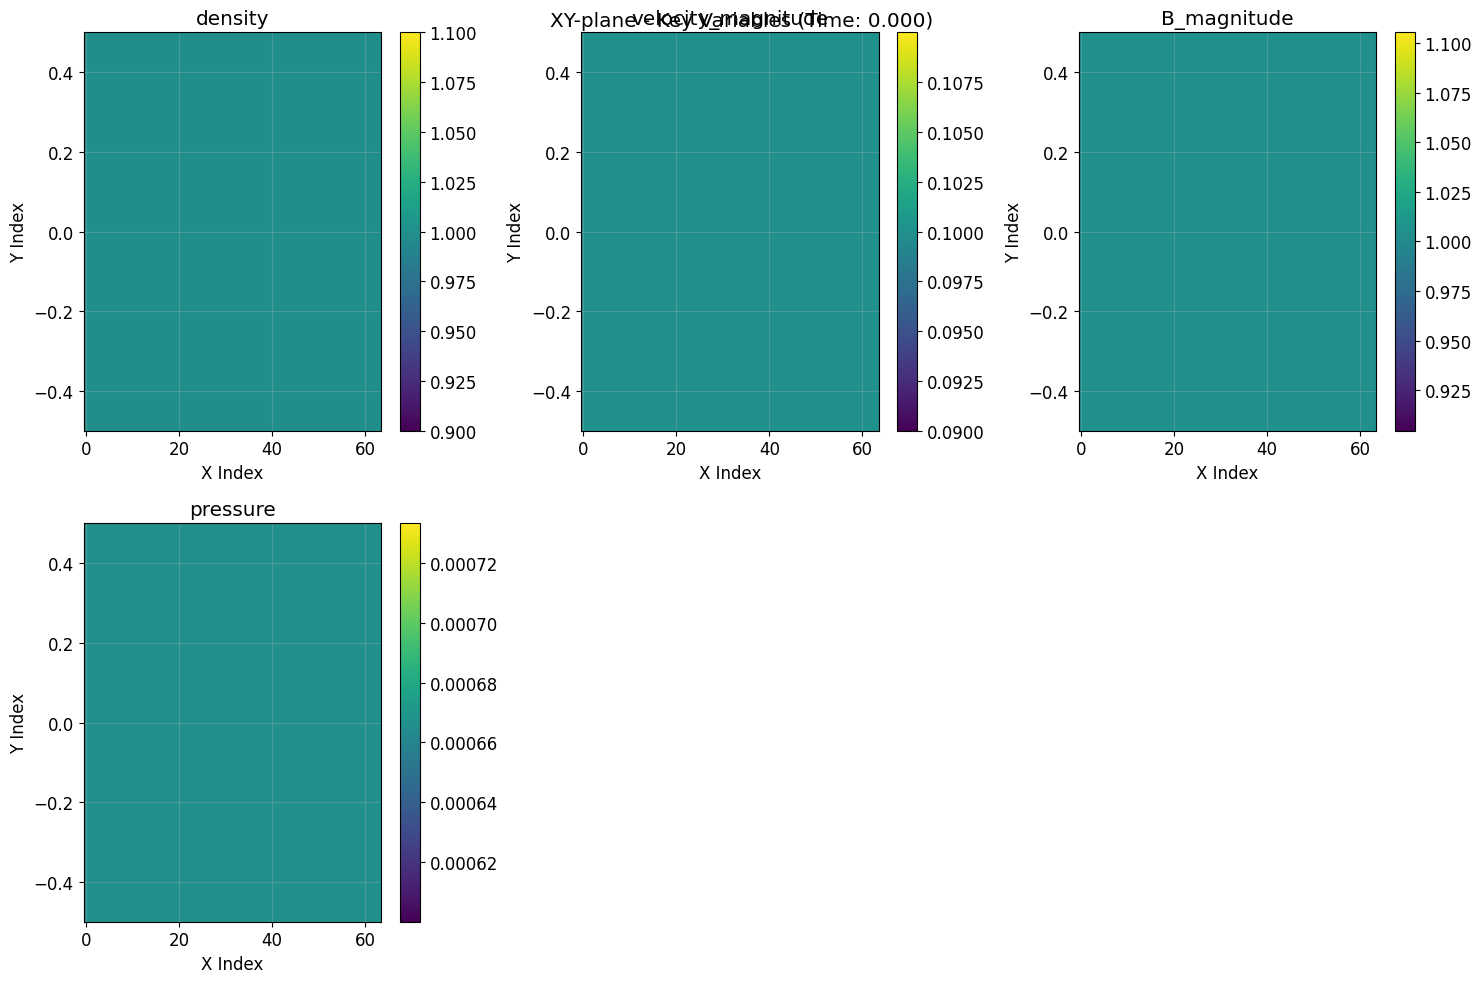

  Skipping velocity field - data too small: (1, 64)
  Skipping magnetic field - data too small: (1, 64)
  Completed visualization for XY-plane

Processing XZ-plane...
  Original dimensions: 64×1×64
  Slice data shape: (64, 64)
  Available variables: ['density', 'velocity_magnitude', 'B_magnitude', 'pressure']


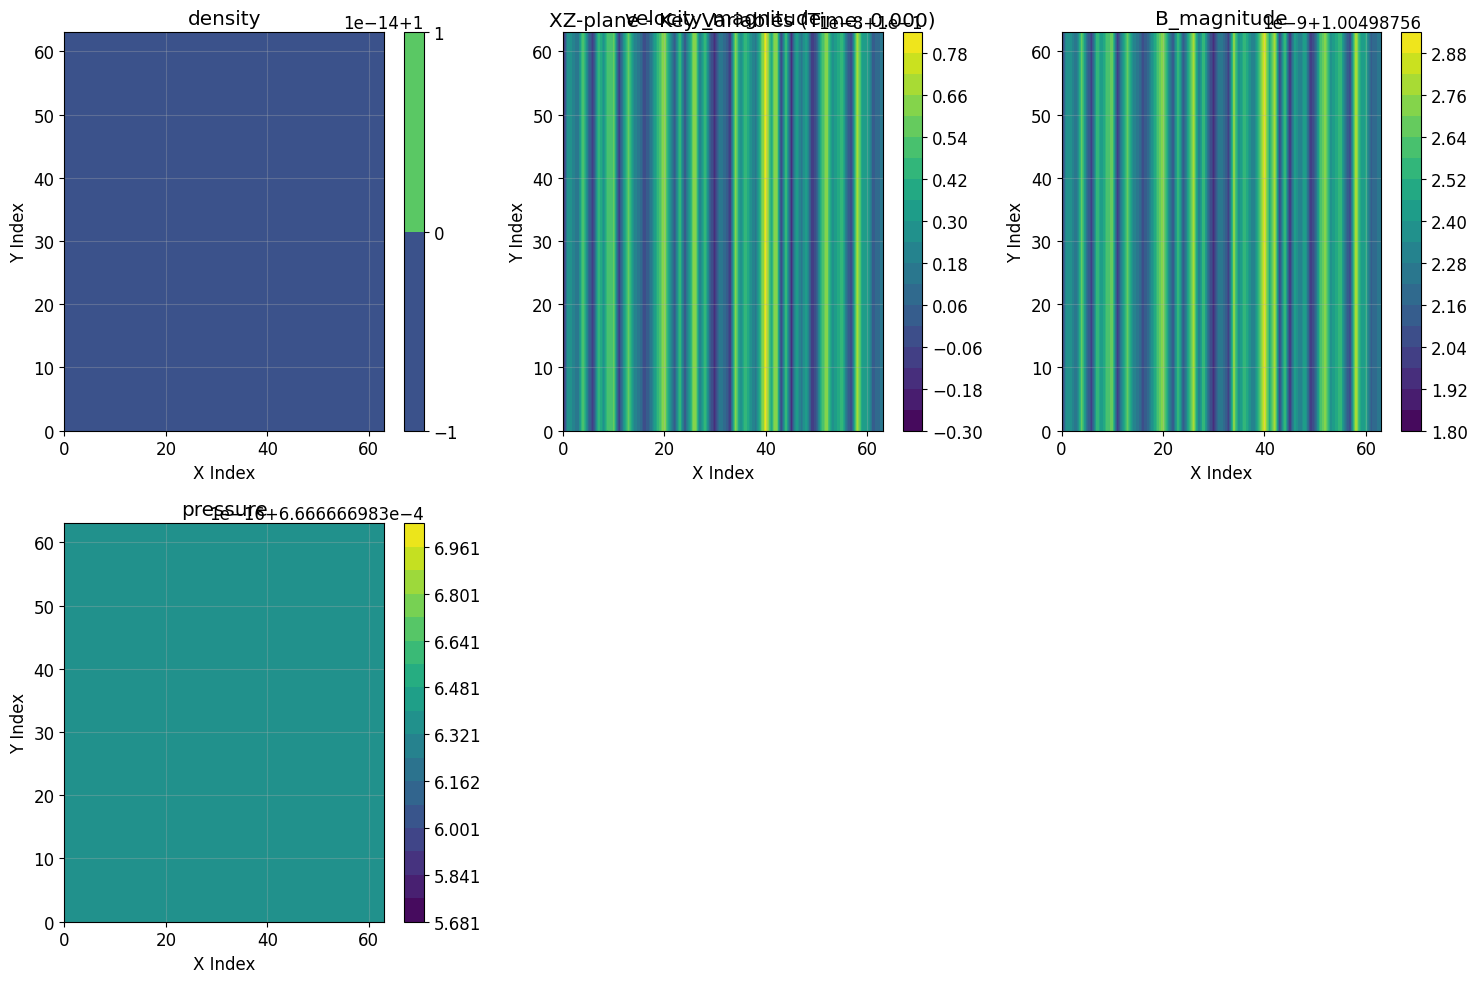

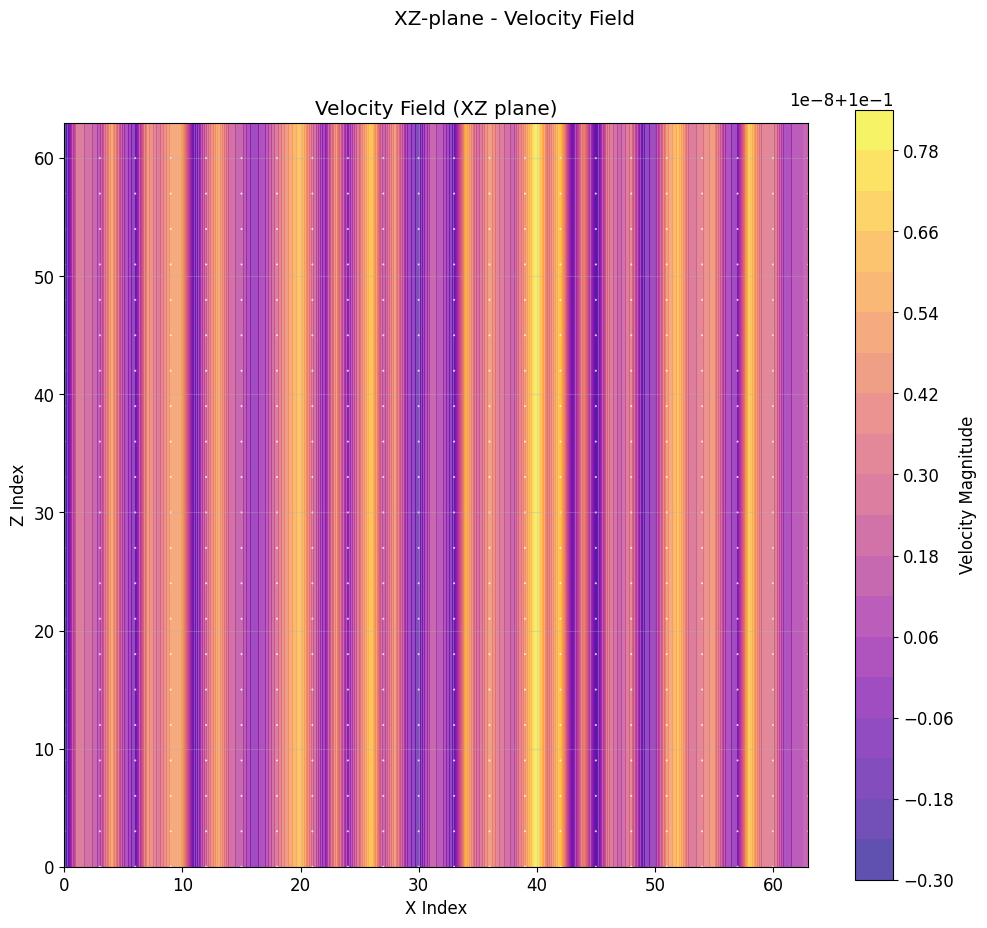

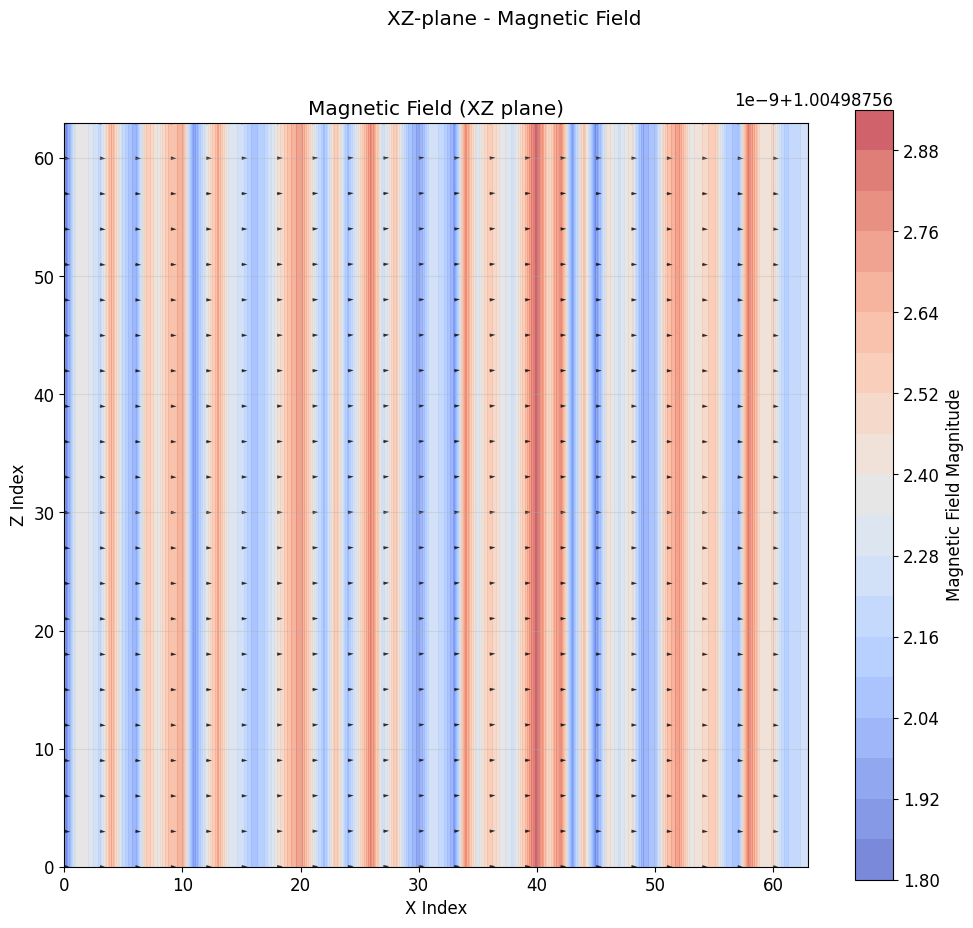

  Completed visualization for XZ-plane

Processing YZ-plane...
  Original dimensions: 1×64×64
  Slice data shape: (64, 1)
  Available variables: ['density', 'velocity_magnitude', 'B_magnitude', 'pressure']


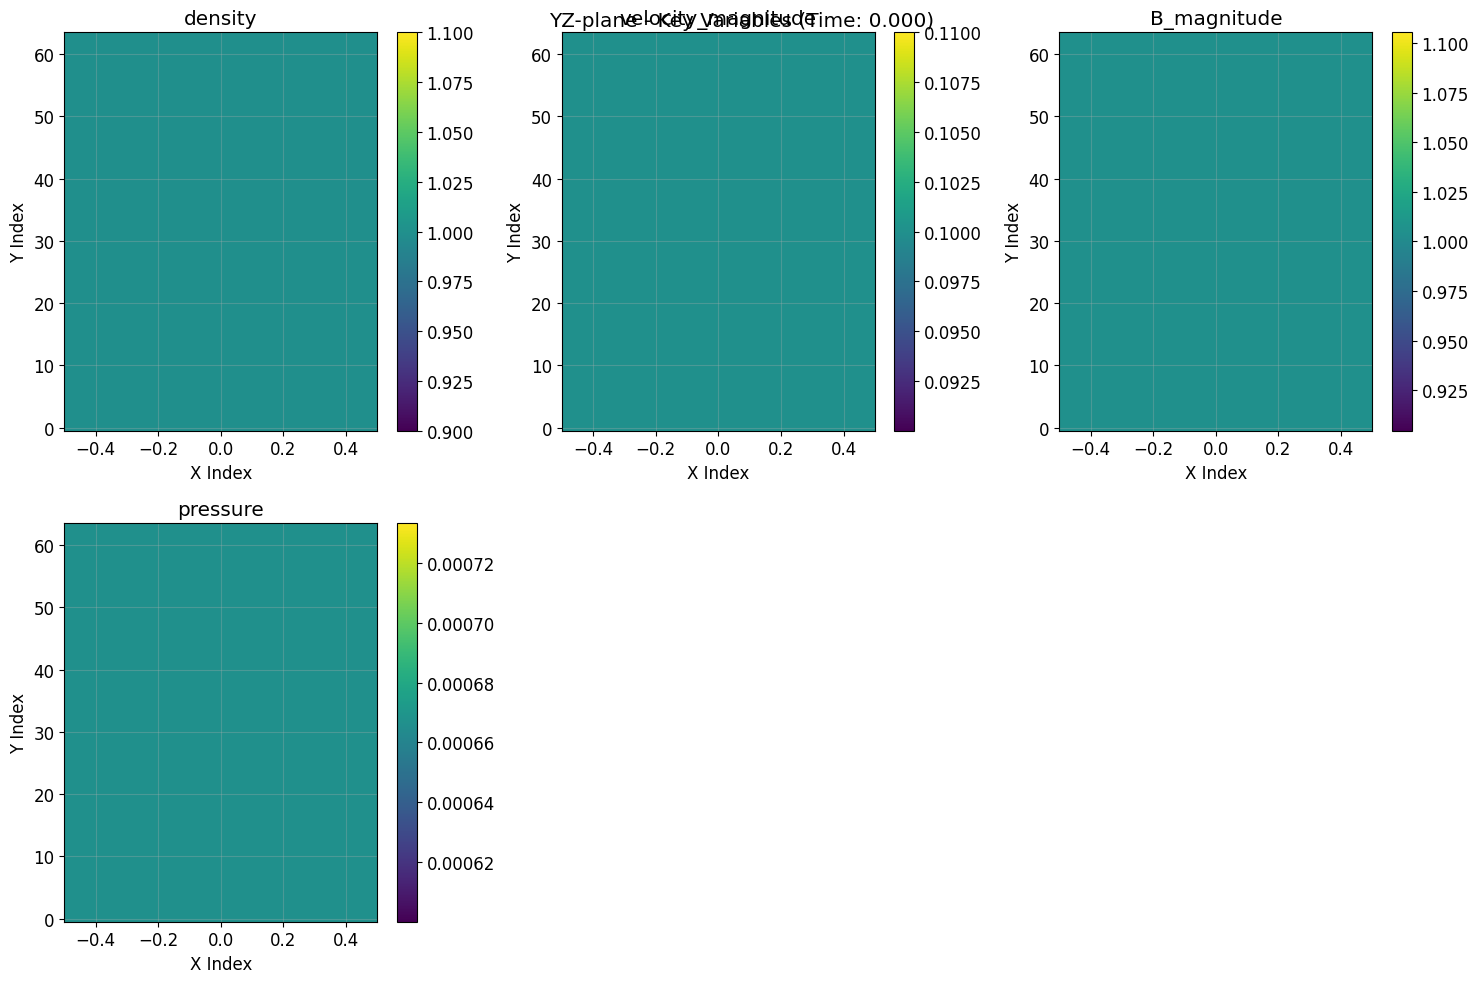

  Skipping velocity field - data too small: (64, 1)
  Skipping magnetic field - data too small: (64, 1)
  Completed visualization for YZ-plane


In [ ]:
# Visualize Sample Data

if sample_data and sample_data['segments']:
    print("Creating sample visualizations...")
    
    # Process each segment (plane)
    plane_names = ['XY-plane', 'XZ-plane', 'YZ-plane']
    
    for i, segment in enumerate(sample_data['segments']):
        if i >= len(plane_names):
            break
            
        print(f"\nProcessing {plane_names[i]}...")
        
        # Parse variables
        variables = parse_mhd_variables(segment)
        if not variables:
            print(f"  No variables found in segment {i+1}")
            continue
        
        # Get dimensions
        nz, ny, nx = segment['dimensions']
        print(f"  Original dimensions: {nz}×{ny}×{nx}")
        
        if nz == 1:  # XY plane
            slice_data = {name: var[0, :, :] for name, var in variables.items()}
            plane_type = 'xy'
        elif ny == 1:  # XZ plane  
            slice_data = {name: var[:, 0, :] for name, var in variables.items()}
            plane_type = 'xz'
        elif nx == 1:  # YZ plane
            slice_data = {name: var[:, :, 0] for name, var in variables.items()}
            plane_type = 'yz'
        else:
            # 3D data - take middle slice
            slice_data = get_plane_slice(variables, 'xy', nz//2)
            plane_type = 'xy'
        
        # Check slice data shape
        first_var = list(slice_data.values())[0]
        print(f"  Slice data shape: {first_var.shape}")
        
        # Skip if data is too small or problematic
        if first_var.size == 0:
            print(f"  Skipping {plane_names[i]} - no data")
            continue
        
        if first_var.ndim != 2:
            print(f"  Skipping {plane_names[i]} - not 2D data")
            continue
        
        # Create basic variable plots
        key_variables = ['density', 'velocity_magnitude', 'B_magnitude', 'pressure']
        available_vars = [var for var in key_variables if var in slice_data]
        
        if available_vars:
            print(f"  Available variables: {available_vars}")
            try:
                fig, axes = create_multi_variable_plot(slice_data, available_vars, 
                                                     plane_type=plane_type, 
                                                     figsize=(15, 10))
                fig.suptitle(f"{plane_names[i]} - Key Variables (Time: {sample_data['time']:.3f})")
                plt.show()
            except Exception as e:
                print(f"  Error creating multi-variable plot: {e}")
        
        # Create velocity field plot if velocity data is available and large enough
        vel_components = ['velocity_x', 'velocity_y'] if plane_type == 'xy' else \
                        ['velocity_x', 'velocity_z'] if plane_type == 'xz' else \
                        ['velocity_y', 'velocity_z']
        
        if all(key in slice_data for key in vel_components):
            vel_data = slice_data[vel_components[0]]
            if vel_data.shape[0] >= 2 and vel_data.shape[1] >= 2:
                try:
                    fig, ax = plot_velocity_field(slice_data, plane_type=plane_type, 
                                                arrow_density=3, scale_factor=0.5)
                    if fig:
                        fig.suptitle(f"{plane_names[i]} - Velocity Field")
                        plt.show()
                except Exception as e:
                    print(f"  Error creating velocity field plot: {e}")
            else:
                print(f"  Skipping velocity field - data too small: {vel_data.shape}")
        
        # Create magnetic field plot if magnetic data is available and large enough
        mag_components = ['B_x', 'B_y'] if plane_type == 'xy' else \
                        ['B_x', 'B_z'] if plane_type == 'xz' else \
                        ['B_y', 'B_z']
        
        if all(key in slice_data for key in mag_components):
            mag_data = slice_data[mag_components[0]]
            if mag_data.shape[0] >= 2 and mag_data.shape[1] >= 2:
                try:
                    fig, ax = plot_magnetic_field(slice_data, plane_type=plane_type, 
                                                arrow_density=3, scale_factor=0.5)
                    if fig:
                        fig.suptitle(f"{plane_names[i]} - Magnetic Field")
                        plt.show()
                except Exception as e:
                    print(f"  Error creating magnetic field plot: {e}")
            else:
                print(f"  Skipping magnetic field - data too small: {mag_data.shape}")
        
        print(f"  Completed visualization for {plane_names[i]}")

else:
    print("No sample data available for visualization. Please load data first.")

Domain overview dimensions: (13, 13, 13)
Reduction factor: 5

Creating XY-plane (Z=middle) overview...


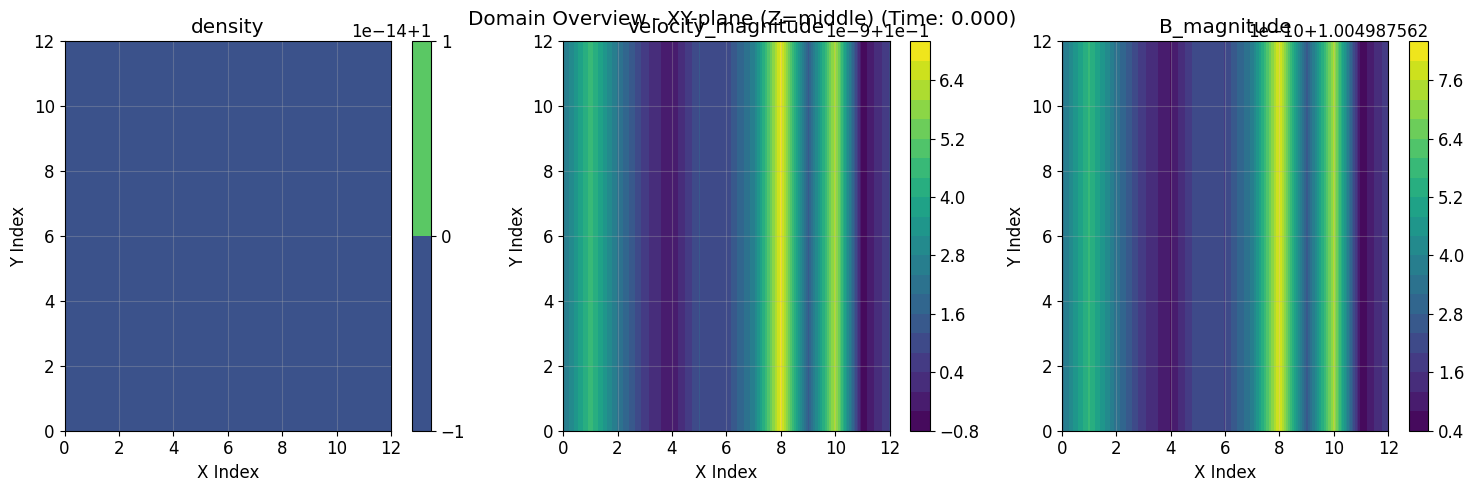

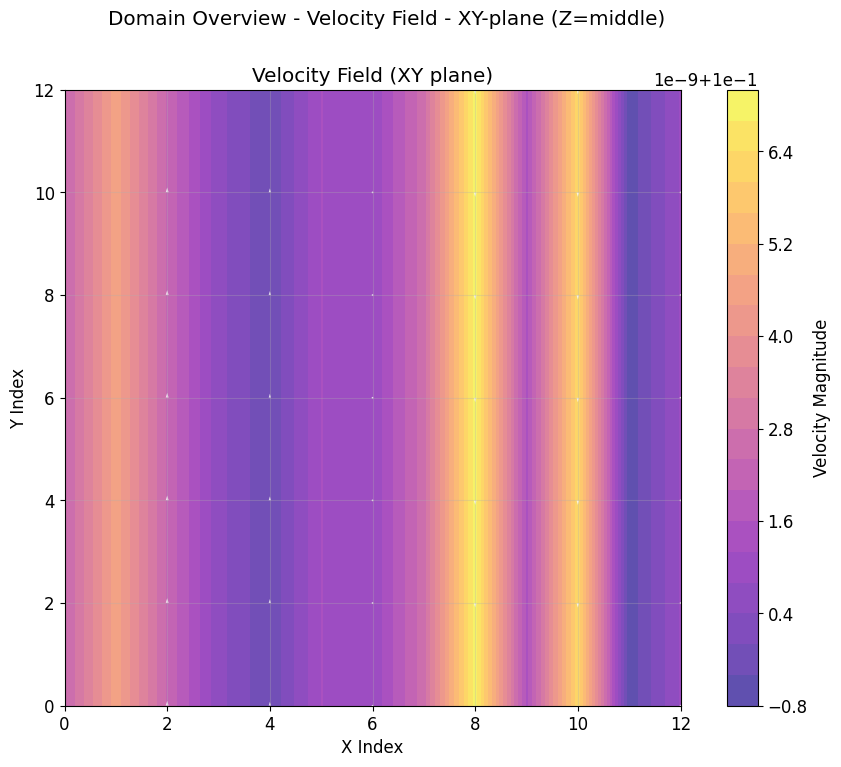


Creating XZ-plane (Y=middle) overview...


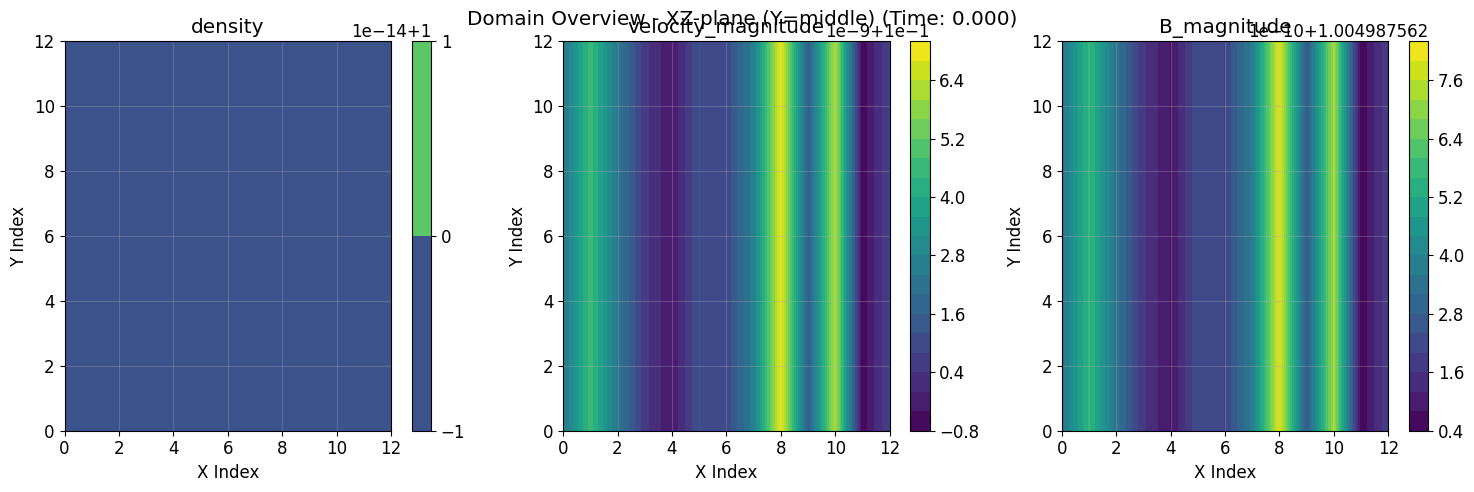

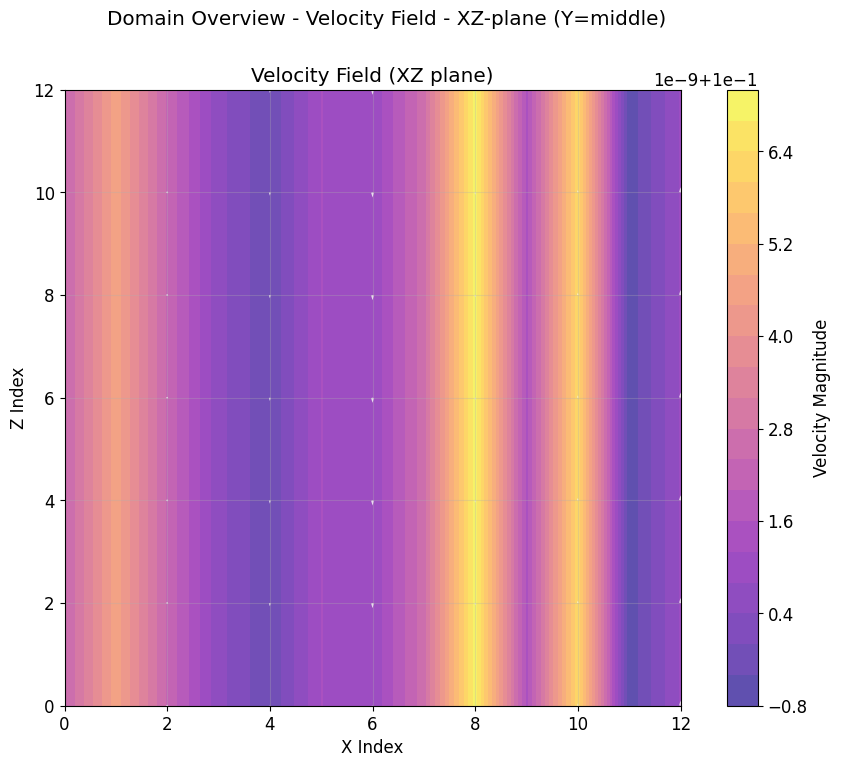


Creating YZ-plane (X=middle) overview...


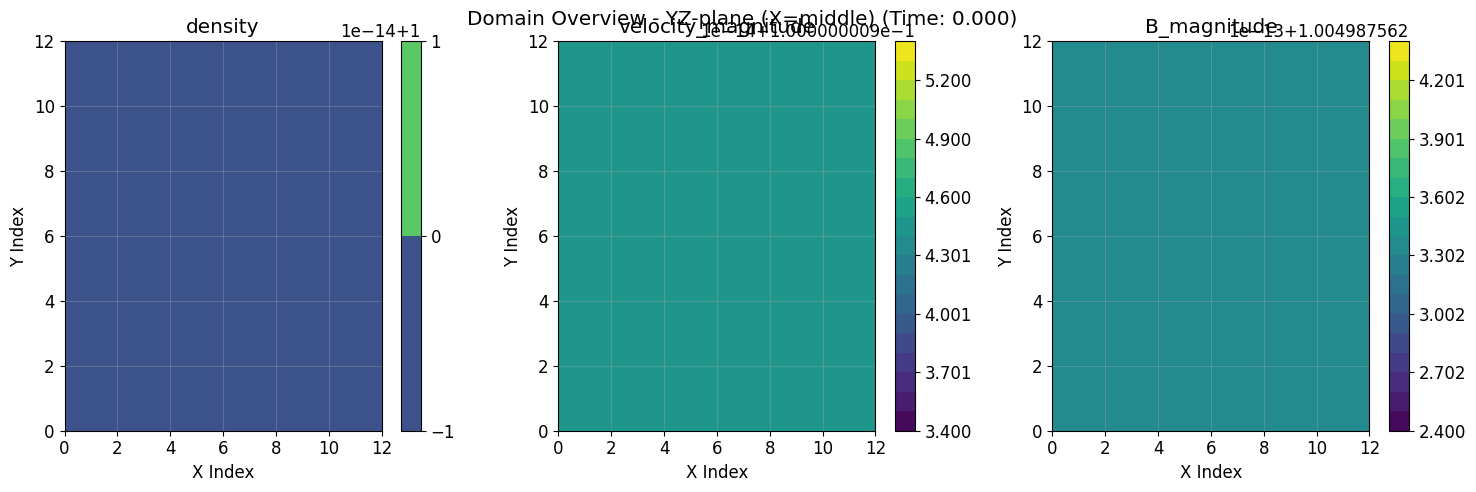

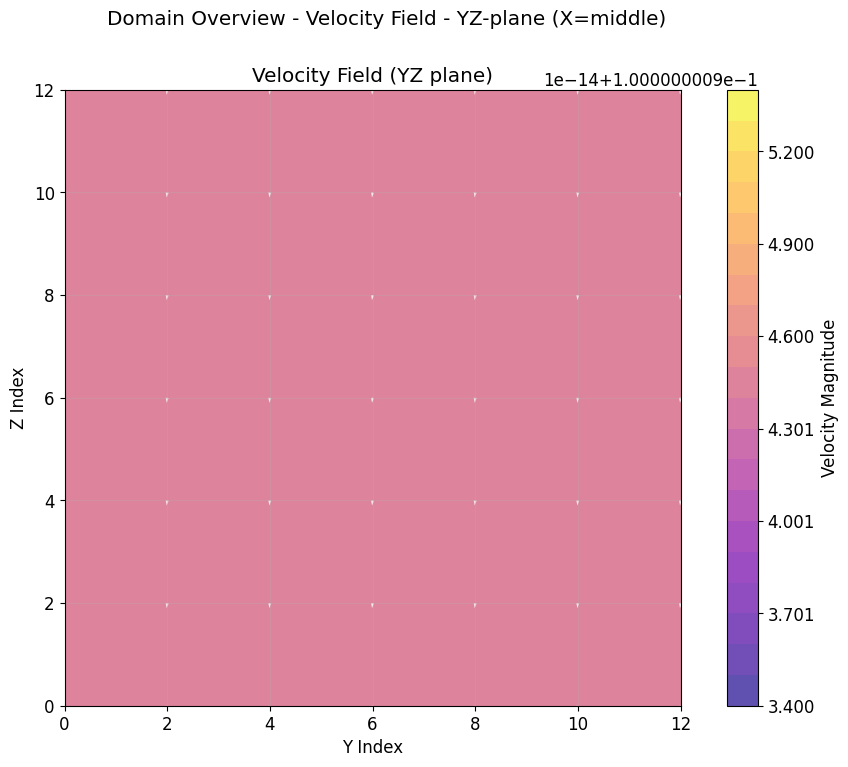

In [ ]:
# Generate Domain Overview Plots

def visualize_domain_overview(data, figsize=(16, 12)):
    """
    Create overview plots of the entire computational domain.
    """
    if not data['domain_overview']:
        print("No domain overview data available")
        return
    
    dov = data['domain_overview']
    print(f"Domain overview dimensions: {dov['dimensions']}")
    print(f"Reduction factor: {dov['reduction_factor']}")
    
    # Parse domain overview variables
    variables = parse_mhd_variables(dov)
    if not variables:
        print("Could not parse domain overview variables")
        return
    
    # Create 3D slices through the middle of the domain
    nz, ny, nx = dov['dimensions']
    
    # XY slice (middle z)
    xy_slice = get_plane_slice(variables, 'xy', nz//2)
    
    # XZ slice (middle y)  
    xz_slice = get_plane_slice(variables, 'xz', ny//2)
    
    # YZ slice (middle x)
    yz_slice = get_plane_slice(variables, 'yz', nx//2)
    
    slices = [xy_slice, xz_slice, yz_slice]
    slice_names = ['XY-plane (Z=middle)', 'XZ-plane (Y=middle)', 'YZ-plane (X=middle)']
    plane_types = ['xy', 'xz', 'yz']
    
    # Plot key variables for each slice
    key_variables = ['density', 'velocity_magnitude', 'B_magnitude']
    available_vars = [var for var in key_variables if var in variables]
    
    for i, (slice_data, slice_name, plane_type) in enumerate(zip(slices, slice_names, plane_types)):
        if slice_data:
            print(f"\nCreating {slice_name} overview...")
            
            # Multi-variable plot
            fig, axes = create_multi_variable_plot(slice_data, available_vars,
                                                 plane_type=plane_type,
                                                 figsize=(15, 5))
            fig.suptitle(f"Domain Overview - {slice_name} (Time: {data['time']:.3f})")
            plt.show()
            
            # Velocity field if available
            if all(f'velocity_{comp}' in slice_data for comp in ['x', 'y']):
                try:
                    fig, ax = plot_velocity_field(slice_data, plane_type=plane_type,
                                                arrow_density=2, scale_factor=1.0,
                                                figsize=(12, 8))
                    if fig:
                        fig.suptitle(f"Domain Overview - Velocity Field - {slice_name}")
                        plt.show()
                except Exception as e:
                    print(f"Error creating velocity field: {e}")

# Visualize domain overview if available
if sample_data and sample_data.get('domain_overview'):
    visualize_domain_overview(sample_data)
else:
    print("No domain overview data available in sample file.")

Creating interactive visualizer...
Use visualizer.display() to show the interactive controls

Running sample time series analysis...
Analyzing time series for density...
Date: 20250819
Time: 0.000000
Grid spacing: 1.000000
Number of segments: 3
Time step: 0
Processor rank: 0
Segment 1: 64×64×1, 8 variables
Segment 2: 64×1×64, 8 variables
Segment 3: 1×64×64, 8 variables
Domain overview: 13×13×13, reduction factor: 5
  Time 0.000: mean=1.000e+00
Date: 20250819
Time: 4.927778
Grid spacing: 1.000000
Number of segments: 3
Time step: 1
Processor rank: 0
Segment 1: 64×64×1, 8 variables
Segment 2: 64×1×64, 8 variables
Segment 3: 1×64×64, 8 variables
Domain overview: 13×13×13, reduction factor: 5
  Time 4.928: mean=1.000e+00
Date: 20250819
Time: 9.854953
Grid spacing: 1.000000
Number of segments: 3
Time step: 2
Processor rank: 0
Segment 1: 64×64×1, 8 variables
Segment 2: 64×1×64, 8 variables
Segment 3: 1×64×64, 8 variables
Domain overview: 13×13×13, reduction factor: 5
  Time 9.855: mean=1.000e

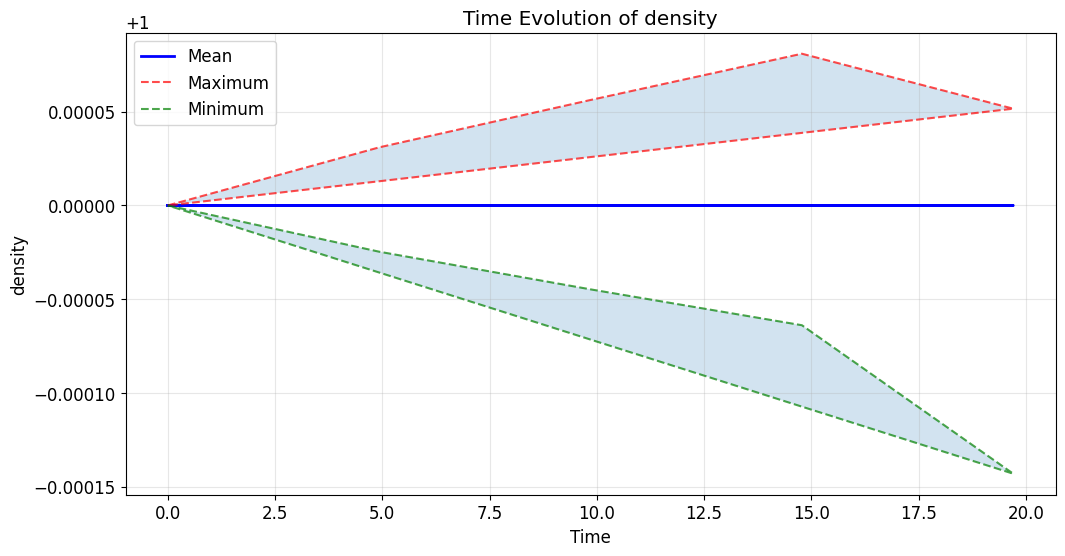

In [ ]:
# Interactive Parameter Controls and Time Series Analysis

class InteractiveFishVisualizer:
    """
    Interactive visualizer for FISH-DS data with widgets.
    """
    
    def __init__(self, dat_files):
        self.dat_files = sorted(dat_files)
        self.current_data = None
        self.current_variables = None
        
        # Extract time steps from filenames
        self.time_steps = []
        for f in self.dat_files:
            # Extract time step number from filename like 'data_00001_0000.dat'
            try:
                parts = f.stem.split('_')
                if len(parts) >= 2:
                    time_step = int(parts[1])
                    self.time_steps.append(time_step)
                else:
                    self.time_steps.append(0)
            except:
                self.time_steps.append(0)
        
        self.setup_widgets()
    
    def setup_widgets(self):
        """Setup interactive widgets."""
        
        # File selection
        self.file_dropdown = widgets.Dropdown(
            options=[(f"Time step {ts} ({f.name})", i) 
                    for i, (f, ts) in enumerate(zip(self.dat_files, self.time_steps))],
            value=0,
            description='File:',
            style={'description_width': 'initial'}
        )
        
        # Segment selection
        self.segment_dropdown = widgets.Dropdown(
            options=[('XY-plane', 0), ('XZ-plane', 1), ('YZ-plane', 2), ('Domain Overview', 3)],
            value=0,
            description='Plane:',
        )
        
        # Variable selection
        self.variable_dropdown = widgets.Dropdown(
            options=[('Density', 'density'), 
                    ('Velocity Magnitude', 'velocity_magnitude'),
                    ('Magnetic Field Magnitude', 'B_magnitude'),
                    ('Pressure', 'pressure'),
                    ('Velocity X', 'velocity_x'),
                    ('Velocity Y', 'velocity_y'),
                    ('Velocity Z', 'velocity_z'),
                    ('Magnetic Field X', 'B_x'),
                    ('Magnetic Field Y', 'B_y'),
                    ('Magnetic Field Z', 'B_z')],
            value='density',
            description='Variable:',
        )
        
        # Colormap selection
        self.colormap_dropdown = widgets.Dropdown(
            options=['viridis', 'plasma', 'coolwarm', 'RdYlBu', 'jet', 'hot', 'seismic'],
            value='viridis',
            description='Colormap:',
        )
        
        # Plot type selection
        self.plot_type_dropdown = widgets.Dropdown(
            options=[('Contour', 'contour'),
                    ('Velocity Field', 'velocity'),
                    ('Magnetic Field', 'magnetic'),
                    ('Multi-variable', 'multi')],
            value='contour',
            description='Plot Type:',
        )
        
        # Update button
        self.update_button = widgets.Button(
            description='Update Plot',
            button_style='primary'
        )
        
        # Bind events
        self.file_dropdown.observe(self.on_file_change, names='value')
        self.update_button.on_click(self.update_plot)
        
        # Layout
        controls = widgets.VBox([
            widgets.HBox([self.file_dropdown, self.segment_dropdown]),
            widgets.HBox([self.variable_dropdown, self.colormap_dropdown]),
            widgets.HBox([self.plot_type_dropdown, self.update_button])
        ])
        
        self.output_area = widgets.Output()
        
        self.widget = widgets.VBox([controls, self.output_area])
    
    def on_file_change(self, change):
        """Handle file selection change."""
        self.load_current_file()
    
    def load_current_file(self):
        """Load the currently selected file."""
        file_idx = self.file_dropdown.value
        filename = self.dat_files[file_idx]
        
        try:
            self.current_data = read_fish_data(str(filename))
            print(f"Loaded: {filename.name}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            self.current_data = None
    
    def update_plot(self, button=None):
        """Update the visualization."""
        if not self.current_data:
            self.load_current_file()
        
        if not self.current_data:
            print("No data available")
            return
        
        with self.output_area:
            clear_output(wait=True)
            
            try:
                segment_idx = self.segment_dropdown.value
                variable_name = self.variable_dropdown.value
                colormap = self.colormap_dropdown.value
                plot_type = self.plot_type_dropdown.value
                
                if segment_idx == 3:  # Domain overview
                    if self.current_data.get('domain_overview'):
                        dov = self.current_data['domain_overview']
                        variables = parse_mhd_variables(dov)
                        if variables:
                            nz, ny, nx = dov['dimensions']
                            slice_data = get_plane_slice(variables, 'xy', nz//2)
                            plane_type = 'xy'
                        else:
                            print("Could not parse domain overview variables")
                            return
                    else:
                        print("No domain overview data available")
                        return
                else:
                    # Regular segment
                    if segment_idx < len(self.current_data['segments']):
                        segment = self.current_data['segments'][segment_idx]
                        variables = parse_mhd_variables(segment)
                        if not variables:
                            print("Could not parse segment variables")
                            return
                        
                        # Determine plane type and extract slice
                        nz, ny, nx = segment['dimensions']
                        if nz == 1:
                            slice_data = {name: var[0, :, :] for name, var in variables.items()}
                            plane_type = 'xy'
                        elif ny == 1:
                            slice_data = {name: var[:, 0, :] for name, var in variables.items()}
                            plane_type = 'xz'
                        elif nx == 1:
                            slice_data = {name: var[:, :, 0] for name, var in variables.items()}
                            plane_type = 'yz'
                        else:
                            slice_data = get_plane_slice(variables, 'xy', nz//2)
                            plane_type = 'xy'
                    else:
                        print("Invalid segment index")
                        return
                
                # Create the requested plot
                if plot_type == 'contour':
                    if variable_name in slice_data:
                        fig, ax = plot_2d_slice(slice_data, variable_name, 
                                              title_prefix=f"Time {self.current_data['time']:.3f}:",
                                              cmap=colormap, figsize=(10, 8))
                        plt.show()
                    else:
                        print(f"Variable '{variable_name}' not available")
                
                elif plot_type == 'velocity':
                    fig, ax = plot_velocity_field(slice_data, plane_type=plane_type,
                                                figsize=(12, 10), arrow_density=3)
                    if fig:
                        fig.suptitle(f"Velocity Field - Time {self.current_data['time']:.3f}")
                        plt.show()
                
                elif plot_type == 'magnetic':
                    fig, ax = plot_magnetic_field(slice_data, plane_type=plane_type,
                                                figsize=(12, 10), arrow_density=3)
                    if fig:
                        fig.suptitle(f"Magnetic Field - Time {self.current_data['time']:.3f}")
                        plt.show()
                
                elif plot_type == 'multi':
                    key_vars = ['density', 'velocity_magnitude', 'B_magnitude', 'pressure']
                    available_vars = [var for var in key_vars if var in slice_data]
                    if available_vars:
                        fig, axes = create_multi_variable_plot(slice_data, available_vars,
                                                             plane_type=plane_type,
                                                             cmap=colormap, figsize=(16, 12))
                        fig.suptitle(f"Multi-variable Plot - Time {self.current_data['time']:.3f}")
                        plt.show()
                    else:
                        print("No variables available for multi-variable plot")
                
            except Exception as e:
                print(f"Error creating plot: {e}")
                import traceback
                traceback.print_exc()
    
    def display(self):
        """Display the interactive widget."""
        display(self.widget)
        self.load_current_file()

def analyze_time_series(dat_files, variable_name='density', segment_idx=0):
    """
    Analyze time evolution of a variable.
    """
    times = []
    values_mean = []
    values_max = []
    values_min = []
    
    print(f"Analyzing time series for {variable_name}...")
    
    for i, filename in enumerate(sorted(dat_files)[:10]):  # Limit to first 10 files
        try:
            data = read_fish_data(str(filename))
            if data and len(data['segments']) > segment_idx:
                segment = data['segments'][segment_idx]
                variables = parse_mhd_variables(segment)
                
                if variables and variable_name in variables:
                    var_data = variables[variable_name]
                    
                    times.append(data['time'])
                    values_mean.append(var_data.mean())
                    values_max.append(var_data.max())
                    values_min.append(var_data.min())
                    
                    print(f"  Time {data['time']:.3f}: mean={var_data.mean():.3e}")
                
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    if times:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(times, values_mean, 'b-', label='Mean', linewidth=2)
        ax.plot(times, values_max, 'r--', label='Maximum', alpha=0.7)
        ax.plot(times, values_min, 'g--', label='Minimum', alpha=0.7)
        ax.fill_between(times, values_min, values_max, alpha=0.2)
        
        ax.set_xlabel('Time')
        ax.set_ylabel(variable_name)
        ax.set_title(f'Time Evolution of {variable_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()
        
        return np.array(times), np.array(values_mean), np.array(values_max), np.array(values_min)
    else:
        print("No data found for time series analysis")
        return None

# Create interactive visualizer if data files are available
if dat_files:
    print("Creating interactive visualizer...")
    visualizer = InteractiveFishVisualizer(dat_files)
    print("Use visualizer.display() to show the interactive controls")
    
    # Example time series analysis
    if len(dat_files) > 1:
        print("\nRunning sample time series analysis...")
        analyze_time_series(dat_files, 'density', segment_idx=0)
else:
    print("No data files available for interactive visualization")

In [ ]:
# Usage Examples and Interactive Demo

# Display the interactive visualizer
if 'visualizer' in globals():
    print("🎮 Interactive Visualizer")

    print("=" * 50)
    print("Use the controls below to explore your FISH-DS simulation data:")
    print("• Select different time steps")
    print("• Choose visualization planes (XY, XZ, YZ)")
    print("• Pick variables to visualize")
    print("• Change colormaps and plot types")
    print("• Click 'Update Plot' to refresh")
    print()
    
    visualizer.display()
else:
    print("Interactive visualizer not available. Please ensure data files are loaded.")

## Additional Analysis Functions

The notebook provides several advanced analysis capabilities:

### 1. **Data Structure**
- **Binary Format**: Fortran unformatted binary files (.dat)
- **3D Grid**: Full 3D magnetohydrodynamics simulation data
- **Variables**: Velocity vectors, magnetic fields, density, entropy/pressure
- **Segments**: XY, XZ, YZ plane slices + domain overview

### 2. **Visualization Types**
- **Contour Plots**: 2D slices with customizable colormaps
- **Vector Fields**: Velocity and magnetic field arrows with magnitude contours
- **Multi-variable**: Side-by-side comparison of multiple quantities
- **Time Series**: Evolution of variables over simulation time

### 3. **Interactive Features**
- **File Selection**: Browse through different time steps
- **Plane Selection**: Choose XY, XZ, YZ planes or domain overview
- **Variable Selection**: Pick from density, velocity, magnetic fields, pressure
- **Colormap Control**: Various color schemes for visualization
- **Plot Types**: Switch between contour, vector field, and multi-variable plots

### 4. **Usage Tips**
- **File Path**: Ensure the data directory path is correct
- **Performance**: Large 3D datasets may take time to load
- **Memory**: Consider using domain overview for quick exploration
- **Customization**: Modify functions for specific analysis needs

### 5. **Example Workflows**
1. **Quick Overview**: Load sample data → View multi-variable plots
2. **Detailed Analysis**: Use interactive controls → Explore different time steps
3. **Time Evolution**: Run time series analysis → Track variable evolution
4. **Custom Analysis**: Modify functions → Add new visualization types